## TP2 : Options américaines

In [4]:
import numpy as np
import matplotlib.pyplot as plt 

### Tache 1 :

In [ ]:
def psi(X , alpha , beta , gamma , G , B) :
    n = X.shape[0]
    Z = np.zeros(n)
    Z[0] = max((1/alpha)*(B[0] - beta*X[1]) , G[0])
    for i in range(1,n-1):
        Z[i] = max((1/alpha)*(B[i] - gamma*Z[i-1]- beta*X[i+1]) , G[i])
    
    Z[n-1] = max((1/alpha)*(B[n-1] - gamma*Z[n-2]) , G[n-1])
    return Z



def GSP(alpha , beta , gamma , B , G, x_0 , epsilon , K) :
    """
    Méthode de Gauss-Seidel projetée (GSP).

    Arguments :
    - alpha, beta, gamma : paramètres du système.
    - B : vecteur des termes indépendants.
    - G : vecteur des contraintes de projection.
    - x_0 : vecteur initial.
    - epsilon : tolérance pour le critère d'arrêt.
    - K : nombre maximal d'itérations.

    Retourne :
    - res : solution approximative.
    - k : nombre d'itérations effectuées.
    """
    def psi(X) :
        n = X.shape[0]
        Z = np.zeros(n)
        Z[0] = max((1/alpha)*(B[0] - beta*X[1]) , G[0])
        for i in range(1,n-1):
            Z[i] = max((1/alpha)*(B[i] - gamma*Z[i-1]- beta*X[i+1]) , G[i])
        
        Z[n-1] = max((1/alpha)*(B[n-1] - gamma*Z[n-2]) , G[n-1])
        return Z
        
    res = x_0
    k = 0 
    while k <= K :
        res_prec = res 
        res = psi(res)
        if np.linalg.norm(res - res_prec) / np.linalg.norm(res_prec) <= epsilon : 
            return (res , k)
        k+=1
    
    return (res , K)
    



### Tache 2 :

In [29]:
def g(x):
    return 3*np.exp(-(x+0.4)**2 / 0.1) + 4*np.exp(-(x-0.4)**2 / 0.2) - 1

In [65]:
alpha = 2
beta = -1
gamma = -1
N = 100
delta_X = 2/(N+1)
B = np.zeros(N)
G = np.array([g(-1 + n*delta_X) for n in range(1,N+1)])
epsilon = 10e-6
K_max = 100000
x_0 = np.ones(N)
res , k  = GSP(alpha , beta , gamma , B , G, x_0 , epsilon , K_max)
# print(res)
# print(psi(res , alpha , beta , gamma , G , B))

print(k)


706


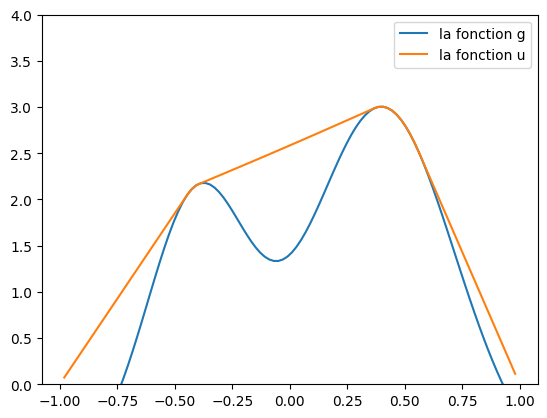

In [66]:
x = [-1 + i*delta_X for i in range(1,N+1)] 
y = [g(x) for x in x]
plt.plot(x , y , label="la fonction g")
plt.plot(x ,res , label = "la fonction u")
plt.ylim(0,4)
plt.legend()
plt.show()


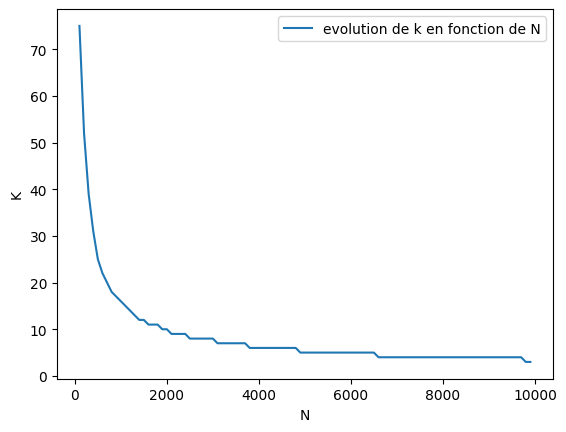

In [46]:
val_N = [N for N in range(100 ,10000, 100)]
val_K = [0 for _ in range(len(val_N))]
for i in range(len(val_N)) : 
    N = val_N[i]
    delta_X = 2/(N+1)
    B = np.zeros(N)
    G = np.array([g(-1+i*delta_X) for i in range(1 ,N+1)])
    x_0 = np.ones(N)
    val_K[i] = GSP(alpha , beta , gamma , B , G, x_0 , epsilon , K_max)[1]
    

plt.plot(val_N , val_K , label="evolution de k en fonction de N")
plt.xlabel("N")
plt.ylabel("K")
plt.legend()
plt.show()
    

### Tache 3: Option américaine

In [63]:
def price_amr(N,M,K,T,sigma,r, delta, payOff,epsilon,K_max):
    U = np.zeros((N,M))
    C = np.zeros((N,M))
    
    a = np.log(K/10)
    b = np.log(10*K)
    
    delta_x = (b-a)/(N+1)
    delta_t = T/M
    
    alpha = (1+ sigma**2 * delta_t/delta_x**2 + r*delta_t)
    beta = -(sigma**2 * delta_t/(2*delta_x**2) + (r - delta - sigma**2/2 )*delta_t/(2*delta_x))
    gamma = (-sigma**2 * delta_t/(2*delta_x**2) + (r - delta - sigma**2/2 )*delta_t/(2*delta_x))
    
    F = np.zeros(N)
    F[0]= -gamma*payOff(np.exp(a),K)
    F[N-1]= -beta*payOff(np.exp(b),K)
    
    G = np.array([payOff(np.exp(a+n*delta_x),K) for n in range(1,N+1)])
    
    # cas initiale :
    U[:,0]=GSP(alpha , beta , gamma , G+F , G, G , epsilon , K_max)[0]
    for i in range(N):
        C[i,0] = 1 if U[i,0] == G[i] else 0
    for m in range(1,M):
        B = U[:,m-1] + F
        x_0 = U[:,m-1]
        U[:,m] = GSP(alpha , beta , gamma , B , G, x_0 , epsilon , K_max)[0]
        for i in range(N):
            C[i,m] = 1 if U[i,m] == G[i] else 0

    
    return U, C


def payoff_call(S,K):
    return max(S-K,0)


def payoff_put(S,K):
    return max(K-S,0)
    
    

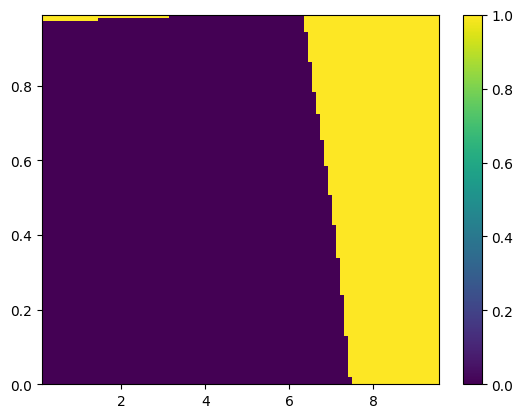

In [81]:
#test
N = 100
M = 100
K = 1
T = 1
sigma = 0.5
r = 0.02
delta = 0.01
epsilon = 10e-12
K_max = 10e6

a = np.log(K/10)
b = np.log(K*10)

delta_x = (b-a)/(N+1)
delta_t = T/M

U,C = price_amr(N,M,K,T,sigma,r, delta, payoff_call,epsilon,K_max)

abs_x = [np.exp(a + i*delta_x) for i in range(1,N+1) ]
ord_y = [T-i*delta_t for i in range(1,M+1) ]


plt.imshow(C.T, aspect='auto', extent=[abs_x[0], abs_x[-1], ord_y[-1], ord_y[0]])

plt.colorbar()
